# Imports

In [2]:
import cv2
import numpy as np
import os
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from skimage.feature import hog

from google.colab import drive
drive.mount('/content/drive')
face_cascade = cv2.CascadeClassifier('/content/drive/My Drive/Colab Notebooks/haarcascade_frontalface_default.xml')

Mounted at /content/drive


# Data Preparation

In [3]:
def load_and_detect_faces(folder_path):
  images = []
  labels = []

  for label in os.listdir(folder_path):
    label_path = os.path.join(folder_path, label)
    if os.path.isdir(label_path):
      for img_file in os.listdir(label_path):
        img_path = os.path.join(label_path, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
          faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
          for (x, y, w, h) in faces:
            face_region = img[y:y+h, x:x+w]
            face_region = cv2.resize(face_region, (64, 64))
            images.append(face_region)
            labels.append(label)

  return images, labels

#Set paths for data
ck_train_path = '/content/drive/My Drive/Colab Notebooks/CK_dataset/train'
ck_test_path = '/content/drive/My Drive//Colab Notebooks/CK_dataset/test'
jaffe_train_path = '/content/drive/My Drive/Colab Notebooks/JAFFE/train'
jaffe_test_path = '/content/drive/My Drive/Colab Notebooks/JAFFE/test'


# load and detect faces in datasets
X_train_ck, y_train_ck = load_and_detect_faces(ck_train_path)
X_test_ck, y_test_ck = load_and_detect_faces(ck_test_path)
X_train_jaffe, y_train_jaffe = load_and_detect_faces(jaffe_train_path)
X_test_jaffe, y_test_jaffe = load_and_detect_faces(jaffe_test_path)


## This feature was used orignally as the datasets were merged (misunderstood requirement, fixed it now!)
jaffe_label_map = {
    'Angry' : 0,
    'Fear' : 1,
    'Happy' : 2,
    'Sad' : 3,
    'Surprise' : 4,
    'Neutral' : 5
}

ck_label_map = {
    'anger' : 0,
    'fear' : 1,
    'happy' : 2,
    'sadness' : 3,
    'surprise' : 4,
    'neutral' : 5
}

#Convert CK labels to integers using CK map
y_train = [ck_label_map[label] for label in y_train_ck]
y_test  = [ck_label_map[label] for label in y_test_ck]

# convert JAFFE labels using JAFFE map
#y_train = [jaffe_label_map[label] for label in y_train_jaffe]
#y_test  = [jaffe_label_map[label] for label in y_test_jaffe]


from collections import Counter

# Count the labels in the combined training set
train_counts = Counter(y_train)
test_counts = Counter(y_test)

print("Training set distribution:")
for label, count in train_counts.items():
    print(f"{label}: {count}")

print("\nTest set distribution:")
for label, count in test_counts.items():
    print(f"{label}: {count}")




Training set distribution:
0: 40
2: 75
3: 41
5: 86
4: 82
1: 16

Test set distribution:
0: 18
2: 30
5: 36
1: 7
4: 35
3: 17


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Preprocess images
def preprocess_images(images):
  preprocessed_images = []
  for img in images:
    # apply histogram equalization
    img = cv2.equalizeHist(img)
    preprocessed_images.append(img)
  return preprocessed_images


# Feature Extraction

In [5]:
# Define parameters for LBP
radius = 6
n_points = 8 * radius

# function to extract LBP features from the cropped face images
#def extract_features(images):

#  lbp_features = []
#  for img in images:

#    img = cv2.resize(img, (64, 64))
#    lbp = local_binary_pattern(img, n_points, radius, method="uniform")

    #histogram of LBP patterns
#    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
#    hist = hist.astype("float")
#    hist /= (hist.sum() + 1e-6)
#    lbp_features.append(hist)

#  return np.array(lbp_features)

# extract LBP features from training and testing face regions
#X_train_features = extract_lbp_features(X_train)
#X_test_features = extract_lbp_features(X_test)



def extract_features(images):

  hog_features = []

  for img in images:
    img = cv2.resize(img, (64, 64))
    features = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2,2), visualize=False)
    hog_features.append(features)

  return np.array(hog_features)

# extract HOG features from training and testing face regions
#X_train_features = extract_features(X_train_jaffe)
#X_test_features  = extract_features(X_test_jaffe)
X_train_features = extract_features(X_train_ck)
X_test_features  = extract_features(X_test_ck)




# display for debug
print(X_test_features[0][:20])
print(X_test_features[1][:20])




[0.39123045 0.         0.01126074 0.         0.0391949  0.016581
 0.         0.15353189 0.39123045 0.21224018 0.09986315 0.01886109
 0.         0.01271186 0.02531639 0.07790277 0.08171981 0.13922828
 0.39123045 0.05569204]
[0.41634699 0.18168056 0.01818534 0.01819769 0.05051362 0.08262893
 0.01376352 0.04511569 0.07780801 0.41634699 0.32706411 0.04741353
 0.         0.         0.         0.         0.01240455 0.07146603
 0.41634699 0.084536  ]


# Matrix

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):

  conf_matrix = confusion_matrix(y_test, y_pred)

  conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

  plt.figure(figsize=(8,8))

  #start plot
  ax = sns.heatmap(conf_matrix, cmap='BuGn', xticklabels=class_names, yticklabels=class_names, cbar=False)

  #iterate through confusion dimensions
  for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
      count = conf_matrix[i, j]
      ax.text(j + 0.5, i + 0.5, f"{count}", ha="center", va="center", color="black", fontsize=10)

  plt.xlabel('Predicted Class')
  plt.ylabel('True Class')
  plt.title('Confusion Matrix')
  plt.show()

# Model Creating - SVM


Accuracy:, 61.54%
SVM Classification Report:
              precision    recall  f1-score   support

       Angry       0.71      0.28      0.40        18
        Fear       0.00      0.00      0.00         7
       Happy       0.93      0.87      0.90        30
         Sad       0.38      0.35      0.36        17
    Surprise       0.83      0.71      0.77        35
     Neutral       0.42      0.72      0.53        36

    accuracy                           0.62       143
   macro avg       0.55      0.49      0.49       143
weighted avg       0.64      0.62      0.60       143

143
[[ 5  0  0  3  0 10]
 [ 0  0  0  4  0  3]
 [ 0  0 26  0  0  4]
 [ 1  0  0  6  0 10]
 [ 0  0  0  1 25  9]
 [ 1  0  2  2  5 26]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


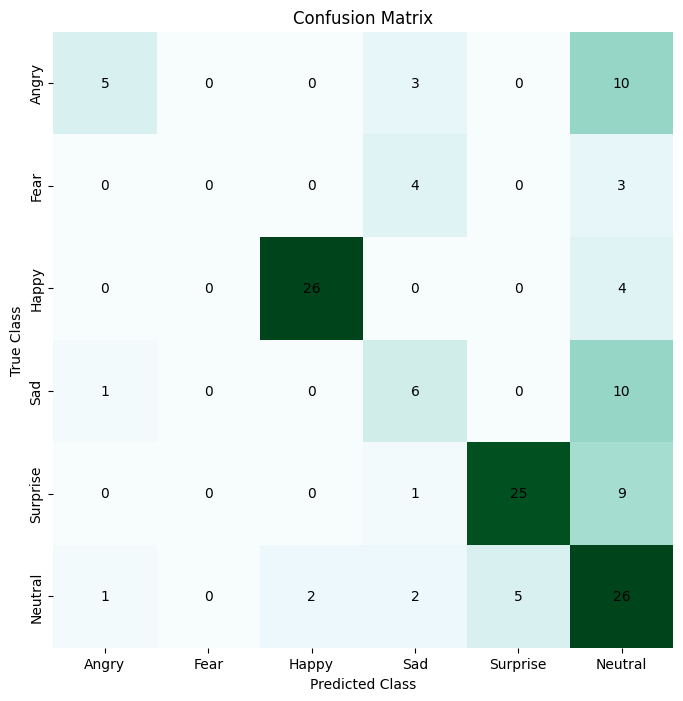

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report




# create SVM pipeline with scaling and RBF
svm_pipeline = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=5, gamma='scale', class_weight='balanced'))


#train the classifier on the training features
svm_pipeline.fit(X_train_features, y_train)

#evaluate the classifier on the testing
y_pred = svm_pipeline.predict(X_test_features)

# calc accuracy

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy:, {accuracy * 100:.2f}%")

class_names = ["Angry", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

print("SVM Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

#confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(len(y_test))
print(conf_matrix)

plot_confusion_matrix(y_test, y_pred, class_names, title="SVM Confusion Matrix")



# Model Creation - KNN



###Cross-validation for K - REF

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# create parameter grid up to 21

param_grid = {'kneighborsclassifier__n_neighbors' : range(1,21)}

## conduct the GridSearchCV

knn_search = GridSearchCV(
    make_pipeline(StandardScaler(), KNeighborsClassifier()),
    param_grid,
    cv=5,
    scoring='accuracy'
)

knn_search.fit(X_train_features, y_train)
best_k = knn_search.best_params_['kneighborsclassifier__n_neighbors']
print(f"Best k: {best_k}")

Best k: 18


Accuracy:, 61.54%
KNN Classification Report:
              precision    recall  f1-score   support

       Angry       0.67      0.22      0.33        18
        Fear       0.00      0.00      0.00         7
       Happy       0.86      0.83      0.85        30
         Sad       0.40      0.24      0.30        17
    Surprise       0.89      0.69      0.77        35
     Neutral       0.44      0.86      0.58        36

    accuracy                           0.62       143
   macro avg       0.54      0.47      0.47       143
weighted avg       0.64      0.62      0.59       143

[[ 4  0  2  3  0  9]
 [ 0  0  0  3  0  4]
 [ 0  0 25  0  1  4]
 [ 1  0  0  4  0 12]
 [ 0  0  0  0 24 11]
 [ 1  0  2  0  2 31]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


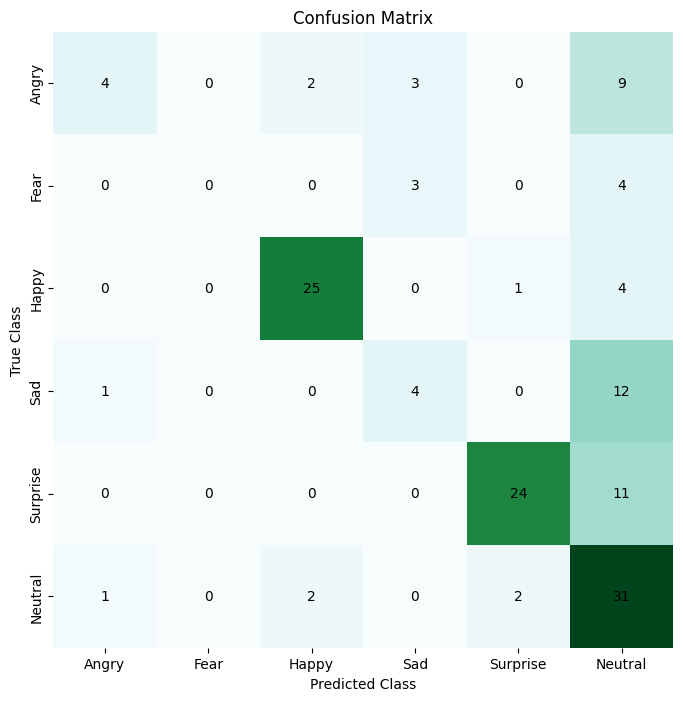

In [9]:


# KNN pipeline
knn_pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=best_k)) # will be base on cross val

#fit pipeline based on training features
knn_pipeline.fit(X_train_features, y_train)

#predict on test set
y_pred_knn = knn_pipeline.predict(X_test_features)

## evaluate the model

# accuracy
knn_accuracy = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy:, {knn_accuracy * 100:.2f}%")

#classification
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn, target_names=class_names))


# confusion matrix
knn_conf_matrix = confusion_matrix(y_test, y_pred_knn)
print(knn_conf_matrix)

class_names = ["Angry", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
plot_confusion_matrix(y_test, y_pred_knn, class_names, title="KNN Confusion Matrix")

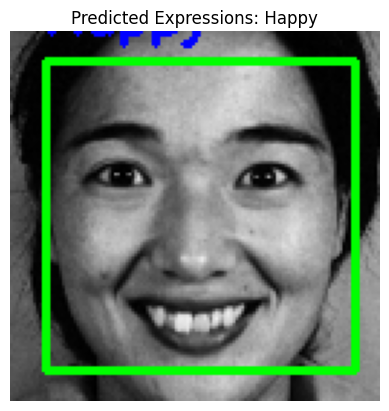

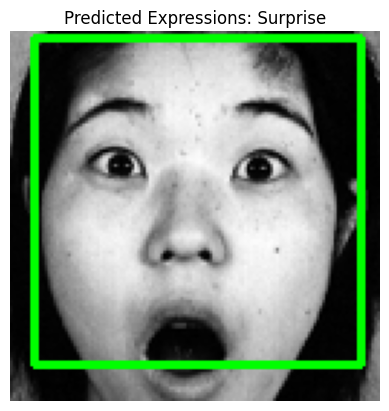

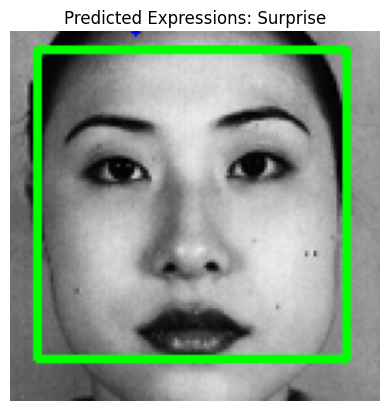

In [10]:


int_to_label = {
    0: "Angry",
    1: "Fear",
    2: "Happy",
    3: "Sad",
    4: "Surprise",
    5: "Neutral"
}

def predict_emotion_example(image_path, model):
    # load image
    img = cv2.imread(image_path)

    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # detect
    faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))



    #array to store
    predictions = []

    #iterate through faces
    for (x, y, w, h) in faces:
        face_region = gray_img[y:y+h, x:x+w]
        face_region = cv2.resize(face_region, (64, 64))  # keep consistent with training

        features = extract_features([face_region])        # wrap in list
        pred_int = model.predict(features)[0]


        # conver to lable
        pred_label = int_to_label[pred_int]
        predictions.append(pred_label)



        # draw bounding box and label
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(img, pred_label, (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    # convert colouring for plotting
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(f"Predicted Expressions: {', '.join(predictions)}")
    plt.axis('off')
    plt.show()

## display for the report
image_paths = ['/content/drive/My Drive/Colab Notebooks/testimages/27.tiff', '/content/drive/My Drive/Colab Notebooks/testimages/23.tiff', '/content/drive/My Drive/Colab Notebooks/testimages/24.tiff']

for i in image_paths:
  image_path = i
  predict_emotion_example(image_path, svm_pipeline)

